## KEYWORD IDENTIFICATION

In [119]:
import requests  # Python library to send HTTP requests.
from bs4 import BeautifulSoup
import re
from collections import Counter
import sqlite3
from typing import Dict, Iterable, Tuple, List
import matplotlib.pyplot as plt

### We will first do scarping, cleaning and counting for the site.

In [114]:
def scrape_clean_count(url: str):

    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------------------------GETTING URL-------------------------------------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------#  
    
    response = requests.get(url)
    # Check if request succeeded
    if response.status_code == 200: # This typically means done succesfully.
        html_content = response.text  # This is the raw HTML.
        print("Successfully fetched the webpage!:", url)
        print("")
    else:
        print("Failed to fetch the webpage. Status code:", response.status_code)
    # with the webpage taken in successfully, we have entire html script that can be checked by uncommeting below line.
    # print(html_content)



    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------------------GETTING, THINGS INSIDE VALID HTML TAGS----------------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------#  

    # now we need to extract the text out from this html.
    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')
    # html
    # ├── head
    # │   └── title → 'IISER Mohali'
    # └── body
    #     ├── h1 → 'Welcome to IISER Mohali'
    #     ├── p  → 'Indian Institute...'
    #     └── p  → 'Established by...'
    # We are assuming that all text content is within these tags.
    # This is a very basic assumption and may not work for all websites.
    # Best way to check is to inspect the website and see where the text lies.
    # Extract text from common tags
    valid_tags = ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'li'] # valid tags only from the html file, h->heading, p->paragraph, li->list
    text = " ".join([element.get_text() for element in soup.find_all(valid_tags)]) # join the entire string into one.
    # print(text) # uncomment this to check the text at this moment, you see everything in the associated tags. 



    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------CLEANING THE TEXT TO GET LOGICAL WORDS (TO SOME EXTENT)-----------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------#  

    # As noted the text is not clean, it contains numbers, symbol, characters and everything, that may or my not be of physical significance.
    # but we logial words, and therefore we do the following:
    Clean_text = text.lower() #convert text to lower case.
    Clean_text =re.sub(r'[^a-z\s]', ' ',Clean_text) # remove all except alphabets and replace with space.
    Clean_text = re.sub(r'\b(?![ai]\b)[a-z]\b',' ',Clean_text) # remove all single letters except a and i, replace with space.
    Clean_text = re.sub(r'\s+',' ',Clean_text).strip() # remove multiple spaces to replace with single space.
    #print(Clean_text) # uncomment here to verify thism, we have the clean string of words from the site seperated by the space.



    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------------COUNTING AND GETTING THE FREQUENCY--------------------------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------# 
    
    # Now we need to go through the string and get the unique words, and frequency (i.e. number of times the word appeared).
    Words = Clean_text.split() # splits the cleaned string over white spaces.
    Word_counter = Counter(Words) # gets frequency of words alongwith words to check uncomment below.
    #print (Word_counter) 
    # for observation properly uncomment below 
    #most_used = Word_counter.most_common() # top 20 or as needed by frequency.
    #for word,freq in most_used:
    #    print(f"{word:>12} : {freq}")
    #
    # Now we have words alongwith their frequency store in the Word_counter, which is the dictionary
    
    return Word_counter # for further analysis


# to see how the function's output looks like
#scrape_clean_count("https://www.iisermohali.ac.in/")

### With word counting done, next we store data in SQLite3.

In [115]:
# SQLite is a self-contained database that stores data in a single file (like data.db).
# You don’t need to run a separate database server, it is built into Python and perfect for “store plus query later” tasks.
# In your case, you want to store:
# each URL,
# each word from that URL, and
# the frequency of that word.

# Database	A single file that holds tables (e.g., keywords.db)
# Table	    A sheet-like structure (e.g., one table for word counts)
# Row	    A single record (e.g., one word’s count for one URL)
# Column	A field in each row (e.g., URL, word, frequency)
# Cursor	A helper that executes SQL commands and returns results
# SQL	    The language we use to create, insert, and read data

#-------------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------Create or Connect to DataBase-------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------# 

def initiate_db(db_path: str = "keywords.db"):
    # Make the data base. Or get connected to the database.
    conn = sqlite3.connect(db_path)

    # To work in it we have cursor. (" way of talking to the database ")
    cur = conn.cursor()

    # Next up tell data base what to do
    # CREATE TABLE  → make a new table.
    # IF NOT EXISTS → don’t complain if it’s already there.
    # The parentheses define columns:
    # id       : unique number auto-generated for each row.
    # url      : text (string).
    # word     : text.
    # frequency: integer.
    # UNIQUE   : prevents repetition.
    cur.execute("""
    CREATE TABLE IF NOT EXISTS word_counts (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        url TEXT NOT NULL,
        word TEXT NOT NULL,
        frequency INTEGER NOT NULL, 
        UNIQUE(url, word) 
    )
    """)

    # Build an internal quick-lookup structure (called idx_url) so queries filtering by the url column are faster.
    conn.execute("CREATE INDEX IF NOT EXISTS idx_url ON word_counts(url)")
    # It speeds up queries like “find where word = 'research'.”
    conn.execute("CREATE INDEX IF NOT EXISTS idx_word ON word_counts(word)")

    # Save the changes you have made.
    conn.commit()   
    return conn



#-------------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------Write and Save in the Database------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------# 

def save_counter_overwrite(conn: sqlite3.Connection, url: str, word_counter: Counter):
    """
    Save all (word, freq) pairs for `url`. If a row for (url,word) already exists,
    overwrite its frequency with the new value (your chosen behavior).
    Uses executemany for speed and runs inside a single transaction.
    """
    # first  ? → url,
    # second ? → word,
    # third  ? → freq.
    # So the code is really saying:
    # Insert a new row into the word_counts table, filling the columns with these values in order.
    # If pair (url, word) is repeated we replace it the latest one.
    sql = """
    INSERT INTO word_counts (url, word, frequency)
    VALUES (?, ?, ?)
    ON CONFLICT(url, word) DO UPDATE
      SET frequency = excluded.frequency
    """
    # If you have many (url, word, freq) rows (like your whole Counter), calling execute() one-by-one is slow.
    # executemany().
    # Make a list.
    data = [(url, word, int(freq)) for word, freq in word_counter.items()]
    cur = conn.cursor()
    cur.executemany(sql, data)
    conn.commit()



#-------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------HELPER FUNCTIONS SINGLE URL----------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

#-------------------------------------------------------------------------------------------------------------------------------#
#-----------------------------------Get words for url in "Word : Frequency" format----------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------# 

def get_words_for_url(conn: sqlite3.Connection, url: str, limit: int = 1000):
    """
    Return top words for a URL ordered by frequency descending.
    """
    sql = "SELECT word, frequency FROM word_counts WHERE url = ? ORDER BY frequency DESC LIMIT ?"
    cur = conn.execute(sql, (url, limit))
    return cur.fetchall()



#-------------------------------------------------------------------------------------------------------------------------------#
#---------------------------------Get top words for url in "Word : Frequency" format--------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

def get_top_words_overall(conn: sqlite3.Connection, limit: int = 1000):
    """
    Return the most frequent words across all URLs combined (sums frequencies).
    """
    sql = """
    SELECT word, SUM(frequency) as total_freq
    FROM word_counts
    GROUP BY word
    ORDER BY total_freq DESC
    LIMIT ?
    """
    cur = conn.execute(sql, (limit,))
    return cur.fetchall()
  

### Defining function for multi url analysis and thus using them to analyze.

In [116]:
#-------------------------------------------------------------------------------------------------------------------------------#
#--------------------------------------------------HELPER FUNCTIONS MULTI URL---------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#


#+#----------- 1.) COMPARE TOP WORDS -----------#-#
def compare_top_words(conn: sqlite3.Connection, url1: str, url2: str, top_n: int = 50):
    # Produce a side-by-side list of words that appear in either URL, with their frequencies in each URL, ordered by combined importance (freq1 + freq2). Useful to spot common strong words and differences.
    # SQL idea (what it does):
    # Build the union of words present in the two URLs. 
    # LEFT JOIN the frequency for url1 and url2 back onto that union.
    # ORDER BY the sum of frequencies so most important combined words appear first.
    # Result row format from the function:
    # (word, freq_in_url1, freq_in_url2)  
    # SELECT → We’re asking SQLite: “Give me a list of words, and for each, show its frequency in site 1 and site 2.”
    # We’ll get three columns:
    # w.word → the word itself (from our temporary list w),
    # freq1  → frequency from URL1,
    # freq2  → frequency from URL2.
    # COALESCE(x, y) → means: use x if it exists, otherwise use y. And also replace NULL or None with '0'.
    # FROM           → This creates a temporary table called w that holds all unique words found in either of the two URLs.
    # UNION merges the results of two SELECT queries but removes duplicates.
    # The ? placeholders are filled by Python ((url1, url2, url1, url2, top_n) later).
    # The LEFT JOIN ... ON a.word = w.word : We now want to attach the frequencies from each URL’s data to this word list.
    sql = """
    SELECT w.word,
           COALESCE(a.freq, 0) AS freq1,
           COALESCE(b.freq, 0) AS freq2
    FROM (
      SELECT word FROM word_counts WHERE url = ?
      UNION
      SELECT word FROM word_counts WHERE url = ?
    ) w
    LEFT JOIN (SELECT word, frequency AS freq FROM word_counts WHERE url = ?) a ON a.word = w.word
    LEFT JOIN (SELECT word, frequency AS freq FROM word_counts WHERE url = ?) b ON b.word = w.word
    ORDER BY (COALESCE(a.freq,0) + COALESCE(b.freq,0)) DESC
    LIMIT ?
    """
    cur = conn.execute(sql, (url1, url2, url1, url2, top_n))
    return [(row[0], row[1], row[2]) for row in cur.fetchall()]


#+#----------- 2.) COMMON WORDS -----------#-#
def common_words(conn: sqlite3.Connection, url1: str, url2: str, min_freq: int = 1):
    # Purpose: list words that appear in both URLs, with frequencies for each, ordered by combined frequency — useful when you only want intersection (shared vocabulary).
    # SQL idea:
    # Join word_counts table with itself on word.
    # Restrict a.url = url1 and b.url = url2.
    # Filter by minimum frequency if you want (min_freq) to avoid noise.
    # Return (word, freq1, freq2) ordered by freq1+freq2.
    # SELECT, word from table a, that is for url1, get freq1 and freq2 for that word in table a and b
    # FROM word_counts a JOIN word_counts b ON a.word = b.word : joining the table to itself, once named a, once named b.
    # If no match for a word then it is gone.
    # Optional filter: AND a.frequency >= ? AND b.frequency >= ? : ignore words that appear only once or twice. Keeps only “significant” shared words.
    # ORDER BY, Sorts by total frequency, so the most common shared words are shown first.
    sql = """
    SELECT a.word, a.frequency AS freq1, b.frequency AS freq2
    FROM word_counts a
    JOIN word_counts b ON a.word = b.word
    WHERE a.url = ? AND b.url = ? AND a.frequency >= ? AND b.frequency >= ?
    ORDER BY (a.frequency + b.frequency) DESC
    """
    cur = conn.execute(sql, (url1, url2, min_freq, min_freq))
    return [(r[0], r[1], r[2]) for r in cur.fetchall()]


#+#----------- 3.) UNCOMMON WORDS -----------#-#
def uncommon_words(conn: sqlite3.Connection, url1: str, url2: str, top_n: int = 50):
    # SELECT a.word, a.frequency → Return the word and its frequency from the left table (we call it a).
    # FROM word_counts a → Use the word_counts table and call it a inside this query (aliasing with a makes the rest shorter).
    # LEFT JOIN word_counts b ON a.word = b.word AND b.url = ? → Try to match each a.word to a row b that has the same word and belongs to url2. This join attempts to find the same word in url2. Because it is a LEFT JOIN, we keep all rows from a whether or not there is a match in b.
    # WHERE a.url = ? AND b.word IS NULL  → Keep only rows where:
    # a is restricted to url1 (a.url = ?), and the join found no match in b (b.word IS NULL — because when LEFT JOIN has no match, columns from b are NULL).
    # So the b.word IS NULL is the key condition that means “this word does not exist in url2”.
    # ORDER BY a.frequency DESC → Sort by decreasing frequency in url1 so the most important unique words show up first.
    # LIMIT ? → Return only the top top_n rows.
    # conn.execute(sql, (url2, url1, top_n)) → Binding order matters: the first ? in the SQL is url2 (for the LEFT JOIN condition), the second ? is url1 (for a.url = ?), third is top_n.
    # For each word that appears in url1, check whether it appears in url2. Return only those that don’t appear in url2, ordered by how frequently they occur in url1.
    sql = """
    SELECT a.word, a.frequency
    FROM word_counts a
    LEFT JOIN word_counts b ON a.word = b.word AND b.url = ?
    WHERE a.url = ? AND b.word IS NULL
    ORDER BY a.frequency DESC
    LIMIT ?
    """
    cur = conn.execute(sql, (url2, url1, top_n))
    return [(r[0], r[1]) for r in cur.fetchall()]


#+#----------- 4.) WORD SEARCH -----------#-#
def search_word_across_urls(conn: sqlite3.Connection, word: str):
    # SELECT url, frequency FROM word_counts → Pick the url and frequency columns.
    # WHERE word = ? → Only rows where the word column exactly matches the parameter (placeholder ?). This is an exact string match.
    # ORDER BY frequency DESC → Show top URLs first, where the word is most frequent.
    # conn.execute(sql, (word,)) → Provide the word parameter as a 1-element tuple.
    sql = "SELECT url, frequency FROM word_counts WHERE word = ? ORDER BY frequency DESC"
    cur = conn.execute(sql, (word,))
    return [(r[0], r[1]) for r in cur.fetchall()]


#-------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------Subsequent functions can be added as needed------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

In [117]:
#-------------------------------------------------------------------------------------------------------------------------------#
#---------------------------------------------------------USAGE AND URLs--------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

if __name__ == "__main__":

    urls = [
        "https://www.iisermohali.ac.in/",
        "https://www.iiserpune.ac.in/",
        "https://www.iisertirupati.ac.in/",
        "https://www.iiserkol.ac.in/"
    ]

    conn = initiate_db("keywords.db")   
    try:
        for u in urls:
            wc: Counter = scrape_clean_count(u)   # our existing function.
            save_counter_overwrite(conn, u, wc)   # after scraping to add in data base.
    finally:
        for i in range(len(urls)):
            for j in range(i+1, len(urls)):   # j starts after i —> avoids duplicates & self-pairs.
                u1, u2 = urls[i], urls[j]
                print ("")
                print ("")
                print (u1 ,"v/s", u2)
                print ("")
                print("Compare: ",compare_top_words(conn, u1, u2))
                print ("")
                print("Common: ",common_words(conn, u1, u2))
                print ("")
                print("Uncommon in : ", u1, " compared to ",u2 ,uncommon_words(conn, u1, u2))
                print ("")
                print("Uncommon in : ", u2, " compared to ",u1 ,uncommon_words(conn, u2, u1))
        conn.close()

Successfully fetched the webpage!: https://www.iisermohali.ac.in/

Successfully fetched the webpage!: https://www.iiserpune.ac.in/

Successfully fetched the webpage!: https://www.iisertirupati.ac.in/

Successfully fetched the webpage!: https://www.iiserkol.ac.in/



https://www.iisermohali.ac.in/ v/s https://www.iiserpune.ac.in/

Compare:  [('and', 0, 35), ('iiser', 15, 15), ('the', 3, 24), ('in', 2, 20), ('of', 8, 14), ('research', 5, 14), ('science', 6, 12), ('for', 2, 13), ('pune', 0, 15), ('events', 3, 11), ('mohali', 14, 0), ('at', 4, 9), ('campus', 2, 11), ('news', 4, 7), ('on', 0, 11), ('faculty', 4, 6), ('to', 2, 8), ('alumni', 1, 7), ('day', 5, 3), ('posted', 0, 8), ('prof', 0, 8), ('sciences', 6, 2), ('by', 3, 4), ('committee', 6, 1), ('facilities', 3, 4), ('india', 2, 5), ('media', 1, 6), ('more', 0, 7), ('awards', 0, 6), ('honours', 0, 6), ('institute', 4, 2), ('national', 1, 5), ('students', 5, 1), ('a', 0, 5), ('about', 0, 5), ('academics', 3, 2), ('centre', 0, 5), ('dr',

### We have got the properly arranged data and helping function defind (also implemented / visulaized).
### Next we work to plots and graphs, to make it more accessible. 

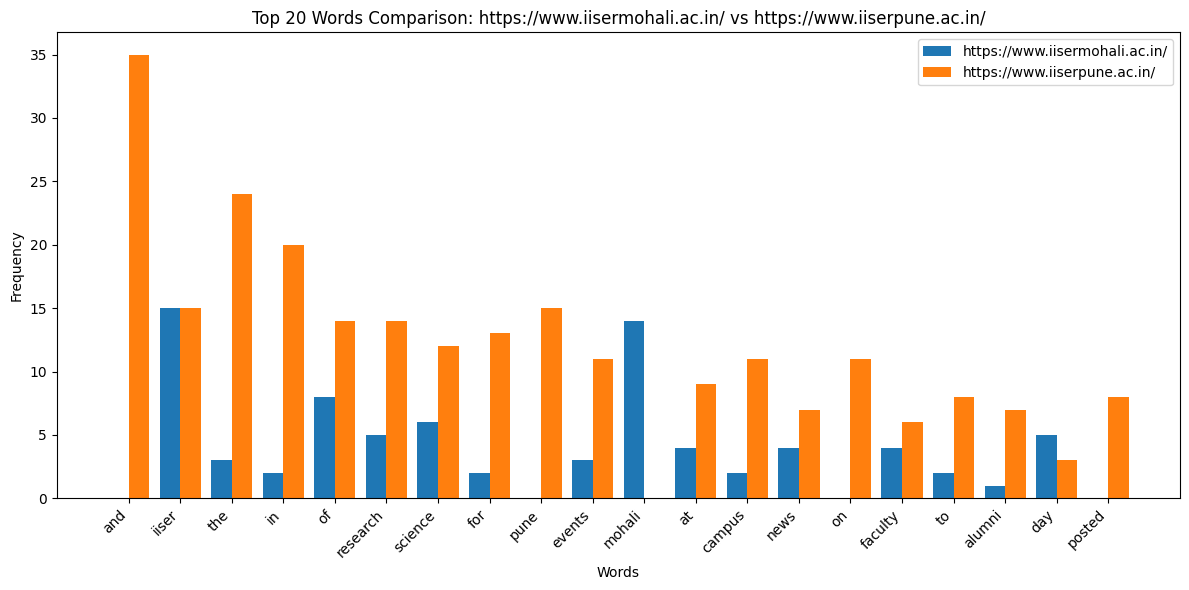

NameError: name 'find_uncommon_words' is not defined

In [120]:
def freq_plots(conn, u1, u2, top_n=20):
    data = compare_top_words(conn=conn, url1=u1, url2=u2, top_n=top_n)
    words = [x[0] for x in data]
    freq1 = [x[1] for x in data]
    freq2 = [x[2] for x in data]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(words)), freq1, width=0.4, label=u1)
    plt.bar([i + 0.4 for i in range(len(words))], freq2, width=0.4, label=u2)
    plt.xticks([i + 0.2 for i in range(len(words))], words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words Comparison: {u1} vs {u2}')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # use the function name you defined earlier: uncommon_words
    uncommon1 = uncommon_words(conn, u1, u2, top_n)
    uncommon2 = uncommon_words(conn, u2, u1, top_n)

    for data, uA, uB in [(uncommon1, u1, u2), (uncommon2, u2, u1)]:
        if data:
            words_unique = [x[0] for x in data]
            freqs_unique = [x[1] for x in data]
            plt.figure(figsize=(10, 5))
            plt.bar(words_unique, freqs_unique, color='orange')
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('Words')
            plt.ylabel('Frequency')
            plt.title(f'Unique Words in {uA} (not in {uB})')
            plt.tight_layout()
            plt.show()


# run plots (same as you had)
conn = sqlite3.connect('keywords.db')

urls = [
    "https://www.iisermohali.ac.in/",
    "https://www.iiserpune.ac.in/",
    "https://www.iisertirupati.ac.in/",
    "https://www.iiserkol.ac.in/"
]

for i in range(len(urls)):
    for j in range(i + 1, len(urls)):
        u1, u2 = urls[i], urls[j]
        print(f"\n\n=== {u1} vs {u2} ===\n")
        freq_plots(conn, u1, u2)

conn.close()
